In [49]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import random 
import tensorflow as tf
import cv2
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
import segmentation_models as sm
from keras.preprocessing.image import ImageDataGenerator
import skimage.transform as trans
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [51]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
w,h = 256,256
batch_size = 16
BACKBONE = "resnet34"
preprocess_input = sm.get_preprocessing(BACKBONE)

In [53]:
path = "/content/drive/MyDrive/Br35H-Mask-RCNN/"

In [54]:
import glob

In [55]:
# load images in file train 
train_images = glob.glob(path + "TRAIN/" + "*.jpg")
train_mask = glob.glob(path + "TRAIN/" + "*.png")
#load images in file val
val_images = glob.glob(path + "VAL/" + "*.jpg")
val_mask = glob.glob(path + "VAL/" + "*.png")

In [56]:
print(train_images[0])
print(train_mask[0])

/content/drive/MyDrive/Br35H-Mask-RCNN/TRAIN/y247.jpg
/content/drive/MyDrive/Br35H-Mask-RCNN/TRAIN/y7.png


In [57]:
def read_image(image_path):
  image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
  image = image / 255
  image = trans.resize(image,(256,256,3))
  image = preprocess_input(image)
  return image
def read_mask(image_path):
  image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
  image = image /255
  image = trans.resize(image,(256,256,3))
  image[image != 0] = 1
  return image

In [58]:
x_train = []
for item in train_images:
  x_train.append(read_image(item))
y_train = []
for item in train_images:
  y_train.append(read_mask(item.replace('.jpg','.png')))
x_val = []
for item in val_images:
  x_val.append(read_image(item))
y_val = []
for item in val_images:
  y_val.append(read_mask(item.replace('.jpg','.png')))


In [59]:
x_train = np.array(x_train).astype('float32')

y_train = np.array(y_train).astype('float32')

x_val = np.array(x_val).astype('float32')

y_val = np.array(y_val).astype('float32')

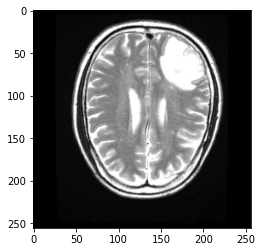

In [60]:
plt.imshow(x_train[0])
plt.show()

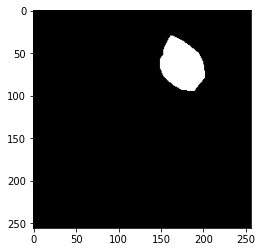

In [61]:
plt.imshow(y_train[0])
plt.show()

In [62]:
image_datagen = ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

image_datagen.fit(x_train,augment=True, seed=42)
image_datagen.fit(y_train,augment=True, seed=42)

x_datagen = image_datagen.flow(x_train,batch_size=32,shuffle=False,seed=42)
y_datagen = image_datagen.flow(y_train,batch_size=32,shuffle=False,seed=42)

In [63]:
len(x_datagen[0])*len(x_datagen)

512

In [64]:
len(x_train)

500

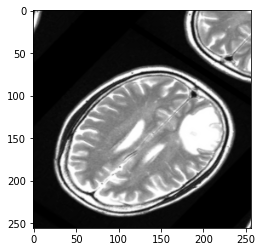

In [65]:
plt.imshow(x_datagen[0][0])
plt.show()

In [66]:
input_datagen = zip(x_datagen,y_datagen)

In [67]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss1 = sm.losses.categorical_focal_dice_loss

In [68]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

In [69]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs , outputs = conv10)

    model.compile(optimizer = opt, loss = loss1, metrics = [iou_score])
    
    #model.summary()

    # if(pretrained_weights):
    # 	model.load_weights(pretrained_weights)
    return model

In [70]:
model = unet()


In [71]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_48[0][0]']              
                                )                                                           

In [72]:
history = model.fit(input_datagen,epochs=100,validation_data=(x_val,y_val),validation_steps=1, steps_per_epoch=64)

Epoch 1/100
10/64 [===>..........................] - ETA: 1:47 - loss: 0.8918 - iou_score: 0.0578

KeyboardInterrupt: ignored

In [ ]:
model.save("point_version2.hdf5")

In [ ]:
iou_score = history.history['iou_score']
val_iou_score = history.history['val_iou_score']

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.plot(iou_score)
plt.plot(val_iou_score)
plt.title("Model iouscore")
plt.legend(['iou_score','val_iou_score'])
plt.show()

In [ ]:
plt.plot(loss)
plt.plot(val_loss)
plt.title("Loss")
plt.legend(['loss','val_loss'])
plt.show()